# Call pacbio consensus sequences in cells

In [98]:
from alignparse.constants import CBPALETTE
import alignparse.ccs
import alignparse.consensus

from Bio.Seq import Seq

import numpy as np

import pandas as pd

import plotnine as p9

import os
import warnings


In [2]:
mutation_df = '../results/pacbio/hashing_highMOI_mutations_str_ex.csv.gz'
cell_df = '../results/viral_tags_bcs_in_cells/hashing_highMOI_cell_barcodes_with_viral_tags.csv.gz'

In [3]:
mutations = pd.read_csv(mutation_df, compression='gzip', low_memory=False)
cell_barcodes = pd.read_csv(cell_df, compression='gzip', low_memory=False)

In [4]:
filter_col = [col for col in mutations
                       if col.startswith('variant_tag')]

mutations = mutations.drop(columns = filter_col)
mutations = mutations.drop(columns = ['name'])

mutations.head()

,query_name,query_clip5,query_clip3,termini5_mutations,termini5_accuracy,termini3_mutations,termini3_accuracy,sequenced_ORF_1_mutations,sequenced_ORF_1_accuracy,sequenced_ORF_2_mutations,...,cellbarcode_accuracy,sequenced_ORF_1_mutations_orf_numbered,sequenced_ORF_2_mutations_orf_numbered,termini5_mutations_orf_numbered,termini3_mutations_orf_numbered,target,all_mutations_orf_numbered,gene,transcript,tag_status
0,m54228_201020_194205/4194462/ccs,0,0,NaN,1.0,ins209GAAAA,1.000000,ins422A,0.999817,NaN,...,1.0,ins1253A,NaN,NaN,ins1910GAAAA,HAmid,ins1253A ins1910GAAAA,fluHA,fluHA,syn
1,m54228_201020_194205/4194571/ccs,0,0,NaN,1.0,del1to208,NaN,del559to870,1.000000,NaN,...,1.0,del1390to1701,NaN,NaN,del1702to1909,HAmid,del1390to1701 del1702to1909,fluHA,fluHA,missing one or more tags
2,m54228_201020_194205/4194630/ccs,0,0,NaN,1.0,ins209AAAAA,0.999409,T345C,0.999998,NaN,...,1.0,T1176C,NaN,NaN,ins1910AAAAA,HAmid,T1176C ins1910AAAAA,fluHA,fluHA,chimeric tags
3,m54228_201020_194205/4194734/ccs,0,0,NaN,1.0,del1to208,NaN,T365C ins411CAACCACCTGGAAAAAAAAAAAAAAAAAAAAAAA...,0.999210,NaN,...,1.0,T1196C ins1242CAACCACCTGGAAAAAAAAAAAAAAAAAAAAA...,NaN,NaN,del1702to1909,HAmid,T1196C del1242to1701 ins1242CAACCACCTGGAAAAAAA...,fluHA,fluHA,missing one or more tags
4,m54228_201020_194205/4194868/ccs,0,1,NaN,1.0,del1to46 ins207ACA G208A,1.000000,ins411CAACCACCTGGAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,0.999988,NaN,...,1.0,ins1242CAACCACCTGGAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,NaN,NaN,del1702to1747 ins1908ACA G1909A,HAmid,del1242to1701 ins1242CAACCACCTGGAAAAAAAAAAAAAA...,fluHA,fluHA,missing one or more tags


In [5]:
col_one_list = mutations['cellbarcode_sequence'].tolist()


In [6]:
barcode_list=[]
for barcode in col_one_list:
    seq = Seq(barcode)
    rv_barcode = seq.reverse_complement()
    rv_barcode = str(rv_barcode)
    barcode_list.append(rv_barcode)
barcode_list 
mutations['cellbarcode_rv'] = pd.DataFrame(barcode_list,columns=['cellbarcode_rv'])
mutations.head()

,query_name,query_clip5,query_clip3,termini5_mutations,termini5_accuracy,termini3_mutations,termini3_accuracy,sequenced_ORF_1_mutations,sequenced_ORF_1_accuracy,sequenced_ORF_2_mutations,...,sequenced_ORF_1_mutations_orf_numbered,sequenced_ORF_2_mutations_orf_numbered,termini5_mutations_orf_numbered,termini3_mutations_orf_numbered,target,all_mutations_orf_numbered,gene,transcript,tag_status,cellbarcode_rv
0,m54228_201020_194205/4194462/ccs,0,0,NaN,1.0,ins209GAAAA,1.000000,ins422A,0.999817,NaN,...,ins1253A,NaN,NaN,ins1910GAAAA,HAmid,ins1253A ins1910GAAAA,fluHA,fluHA,syn,GTGAGTTCATCCTAAG
1,m54228_201020_194205/4194571/ccs,0,0,NaN,1.0,del1to208,NaN,del559to870,1.000000,NaN,...,del1390to1701,NaN,NaN,del1702to1909,HAmid,del1390to1701 del1702to1909,fluHA,fluHA,missing one or more tags,CTCTCAGTCTACCAGA
2,m54228_201020_194205/4194630/ccs,0,0,NaN,1.0,ins209AAAAA,0.999409,T345C,0.999998,NaN,...,T1176C,NaN,NaN,ins1910AAAAA,HAmid,T1176C ins1910AAAAA,fluHA,fluHA,chimeric tags,TCGGGACAGTGTACAA
3,m54228_201020_194205/4194734/ccs,0,0,NaN,1.0,del1to208,NaN,T365C ins411CAACCACCTGGAAAAAAAAAAAAAAAAAAAAAAA...,0.999210,NaN,...,T1196C ins1242CAACCACCTGGAAAAAAAAAAAAAAAAAAAAA...,NaN,NaN,del1702to1909,HAmid,T1196C del1242to1701 ins1242CAACCACCTGGAAAAAAA...,fluHA,fluHA,missing one or more tags,TCATTGTTCAACCTTT
4,m54228_201020_194205/4194868/ccs,0,1,NaN,1.0,del1to46 ins207ACA G208A,1.000000,ins411CAACCACCTGGAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,0.999988,NaN,...,ins1242CAACCACCTGGAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,NaN,NaN,del1702to1747 ins1908ACA G1909A,HAmid,del1242to1701 ins1242CAACCACCTGGAAAAAAAAAAAAAA...,fluHA,fluHA,missing one or more tags,TTTGGTTGTGGCCCAT


In [86]:
df_merged = pd.merge(mutations, cell_barcodes,
                       how='left', left_on=['cellbarcode_rv'],
                       right_on=['cell_barcode'])

,query_name,query_clip5,query_clip3,termini5_mutations,termini5_accuracy,termini3_mutations,termini3_accuracy,sequenced_ORF_1_mutations,sequenced_ORF_1_accuracy,sequenced_ORF_2_mutations,...,frac_viral_UMIs,infected,infecting_viral_tag,viral_tag_doublet,viral_tag_major,viral_tag_minor,viral_tag_major_infected,viral_tag_minor_infected,viral_tag_major_counts,viral_tag_minor_counts
0,m54228_201020_194205/4194462/ccs,0,0,NaN,1.0,ins209GAAAA,1.000000,ins422A,0.999817,NaN,...,0.543392,True,wt,False,wt,syn,True,False,4998.0,38.0
1,m54228_201020_194205/4194571/ccs,0,0,NaN,1.0,del1to208,NaN,del559to870,1.000000,NaN,...,0.552953,True,wt,False,wt,syn,True,False,2940.0,31.0
2,m54228_201020_194205/4194630/ccs,0,0,NaN,1.0,ins209AAAAA,0.999409,T345C,0.999998,NaN,...,0.539057,True,wt,False,wt,syn,True,False,3265.0,23.0
3,m54228_201020_194205/4194734/ccs,0,0,NaN,1.0,del1to208,NaN,T365C ins411CAACCACCTGGAAAAAAAAAAAAAAAAAAAAAAA...,0.999210,NaN,...,0.097521,True,wt,False,wt,syn,True,False,492.0,17.0
4,m54228_201020_194205/4194868/ccs,0,1,NaN,1.0,del1to46 ins207ACA G208A,1.000000,ins411CAACCACCTGGAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,0.999988,NaN,...,0.632783,True,wt,False,wt,syn,True,False,2912.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236079,m54228_201020_194205/74908468/ccs,0,0,NaN,1.0,del1to13,NaN,del557to559 G562A del566to2275,0.999998,NaN,...,0.684611,True,wt,False,wt,syn,True,False,16583.0,137.0
236080,m54228_201020_194205/74908522/ccs,0,0,NaN,1.0,ins13C T13A,1.000000,del183to2160,0.999996,NaN,...,0.343393,True,both,True,syn,wt,True,True,4259.0,3519.0
236081,m54228_201020_194205/74908601/ccs,0,0,NaN,1.0,T12C T13C,1.000000,del183to2160,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236082,m54228_201020_194205/74908638/ccs,0,0,NaN,1.0,del1to13,NaN,del553to2275,1.000000,NaN,...,0.416608,True,both,True,wt,syn,True,True,2432.0,1243.0


In [89]:
# filter for  cells that don't have chimeric tags
df_merged = df_merged.loc[df_merged['tag_status'] != 'chimeric tags']

## CCSs in infected and uninfected cells

In [90]:
print('How many CCSs are called in infected vs uninfected cells:')
df_merged.groupby(['infected']).agg({'infected': 'count'})

How many CCSs are called in infected vs uninfected cells:


,infected
infected,
False,357
True,169129


In [91]:
uninfected = df_merged.loc[df_merged['infected'] == False]
uninfected_barcode_count = (
                            uninfected
                            .groupby(['cell_barcode'])
                            .agg({'cell_barcode': 'count'})
)
uninfected_barcode_count = (
                            uninfected_barcode_count
                            .rename(columns={'cell_barcode': 'cell_barcode',
                                             'cell_barcode': 'count'})
)


This is how many  cells


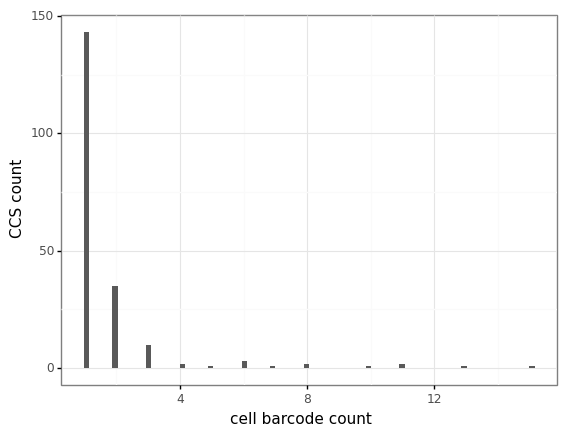

In [92]:
p = (
    p9.ggplot(uninfected_barcode_count,
              p9.aes(x = 'count'))
    + p9.geom_histogram(bins=80)
    + p9.theme(axis_text_x=p9.element_text(angle=90),
               panel_grid_major_x=p9.element_blank()
               )
    + p9.theme_bw()
    + p9.xlab("cell barcode count")
    + p9.ylab("CCS count")
)
_ = p.draw()
print('This is how many  cells')

In [93]:
infected = df_merged.loc[df_merged['infected'] == True]

infected_barcode_count = (
                          infected
                          .groupby(['cell_barcode'])
                          .agg({'cell_barcode': 'count'})
)
infected_barcode_count = (
                          infected_barcode_count
                          .rename(columns={'cell_barcode': 'count'})
)

max number of CCSs per cell barcode is 1049


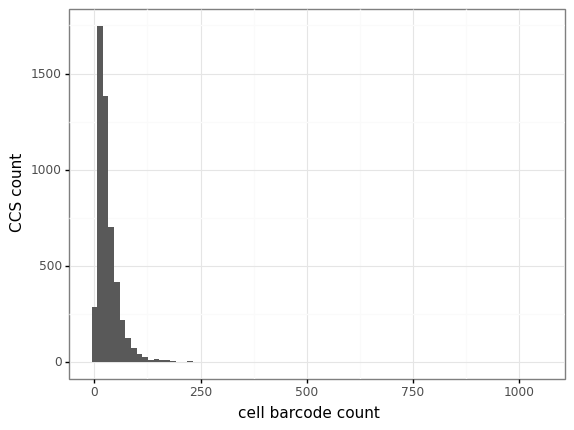

In [94]:
p = (
    p9.ggplot(infected_barcode_count,
              p9.aes(x = 'count'))
    + p9.geom_histogram(bins=80)
    + p9.theme(axis_text_x=p9.element_text(angle=90),
               panel_grid_major_x=p9.element_blank()
               )
    + p9.theme_bw()
    + p9.xlab("cell barcode count")
    + p9.ylab("CCS count")
)
_ = p.draw()

print('max number of CCSs per cell barcode is', infected_barcode_count['count'].max())

## UMI counts

In [95]:
UMI_count = df_merged.groupby(['UMI_sequence']).agg({'UMI_sequence': 'count'})
UMI_count = UMI_count.rename(columns={'UMI_sequence': 'UMI', 'UMI_sequence': 'count'})

max number of CCSs per UMI is 63


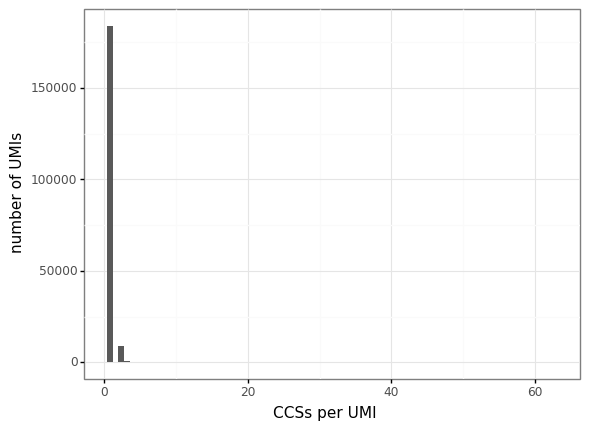

In [96]:
p = (
    p9.ggplot(UMI_count,
              p9.aes(x = 'count'))
    + p9.geom_histogram(bins=80)
    + p9.theme(axis_text_x=p9.element_text(angle=90),
               panel_grid_major_x=p9.element_blank()
               )
    + p9.theme_bw()
    + p9.xlab("CCSs per UMI")
    + p9.ylab("number of UMIs")
)
_ = p.draw()

print('max number of CCSs per UMI is', UMI_count['count'].max())

In [97]:
UMI_count_table = (
                  UMI_count
                  .rename(columns={'count': 'no_of_CCSs'})
                  .groupby(['no_of_CCSs'])
                  .agg({'no_of_CCSs': 'count'})
)
print('Here\'s how many CCSs each UMI has:')
UMI_count_table.rename(columns={'no_of_CCSs': 'no of UMIs'})

Here's how many CCSs each UMI has:


,no of UMIs
no_of_CCSs,
1,183837
2,8766
3,670
4,43
5,9
63,1


## Call consensus

In [101]:
infected = infected.replace(np.nan, '', regex=True)

alignparse.consensus.simple_mutconsensus(
    infected,
    group_cols=['UMI_sequence', 'cellbarcode_sequence'],
    mutation_col='all_mutations_orf_numbered',
    max_sub_diffs=1,
    max_indel_diffs=2,
    max_minor_sub_frac=0.1,
    max_minor_indel_frac=0.25,
    support_col='variant_call_support'
)

ValueError: cannot match mutation G-24T
(in G-24T del1543to1543)

In [110]:


infected[infected.all_mutations_orf_numbered.isin(['G-24T del1543to1543'])]

,query_name,query_clip5,query_clip3,termini5_mutations,termini5_accuracy,termini3_mutations,termini3_accuracy,sequenced_ORF_1_mutations,sequenced_ORF_1_accuracy,sequenced_ORF_2_mutations,...,frac_viral_UMIs,infected,infecting_viral_tag,viral_tag_doublet,viral_tag_major,viral_tag_minor,viral_tag_major_infected,viral_tag_minor_infected,viral_tag_major_counts,viral_tag_minor_counts
220108,m54228_201020_194205/73662976/ccs,0,0,G4T,0.999993,,0.999959,del432to432,0.999051,,...,0.556568,True,wt,False,wt,syn,True,False,5464.0,58.0
